# Theta Model Forecaster

The theta model is a forecasting method presented by V. Assimakopoulos and K. Nikolopoulos. The basic idea behind this method is the decomposition of the original time series into **short and long term components**. Other popular methods decompose time series into a seasonal, a trend and an error component. However, the Theta Model produces new time series by modifying the **second order difference** of the original time series by multiplying it by a real value, called theta. Then, we produce forecasts for each of the underlying time series components (**extrapolation**) and finally we **combine** all forecasts to obtain the final forecast for the original time series.

## 0. Preliminaries

In this tutorial we will use two datasets: shampoo sales and the airline dataset. The first one describes the monthly number of sales of shampoo over a 3 year period. The units are a sales count. The second one describes the monthly totals of international airline passengers, 1949 to 1960.

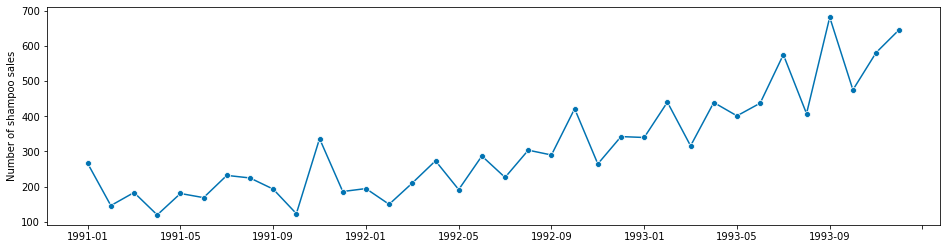

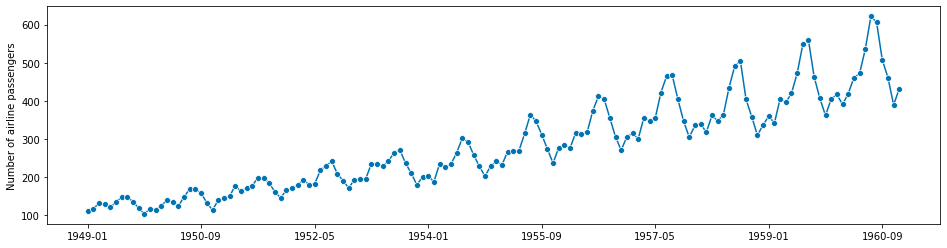

In [1]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.forecasting.theta import ThetaModel
from functions import mae
from sktime.forecasting.theta import ThetaForecaster
from statsmodels.tsa.api import SimpleExpSmoothing
from sktime.forecasting.arima import AutoARIMA

X = load_shampoo_sales()
fig, ax =  plot_series(X)
y = load_airline()
fig, ax =  plot_series(y)

## 1. Understanding theta lines

* Explain how we modify the local curvatures of the original time series
* Explain and give the definition of second order difference

In [2]:
x = X.values

In [3]:
def get_x_data(x):
    return x[2:]-2*x[1:-1]+x[:-2]

Grzegorz Dudek 1 paper
* Equation of the theta line
* Analytical solution of the equation of the minimization problem 
* formulas for computing a and b

In [4]:
def get_theta_line(x, theta):
    n = len(x)
    b = (6/(n*n -1))*((2/n)*np.dot(x, np.arange(1, len(x)+1)) 
                     - ((1+n)/n)*np.sum(x))
    a = (1/n)*np.sum(x)-((n+1)/2)*b
    z_t = theta*x +(1-theta)*(a+b*np.arange(1,n+1))
    return z_t

In [5]:
theta_values = [0, 0.5, 1,  2]
z_lines = []
legend = ["original time series"]
for z in theta_values:
    legend.append("theta line with theta = {}".format(z))
    z_lines.append(pd.Series(get_theta_line(x,z ), index = X.index))

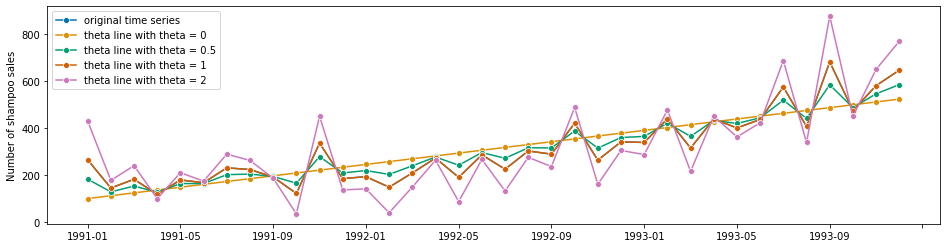

In [6]:
x_data = get_x_data(x)
theta = 1

fig, ax =  plot_series(X, z_lines[0], z_lines[1], z_lines[2], z_lines[3], labels=legend)

## 2. Theta Model pipeline
Explain complete pipeline of the model:
* Deseasonalization
* Decomposition
* Extrapolation
* Combination
* Reseasonalization

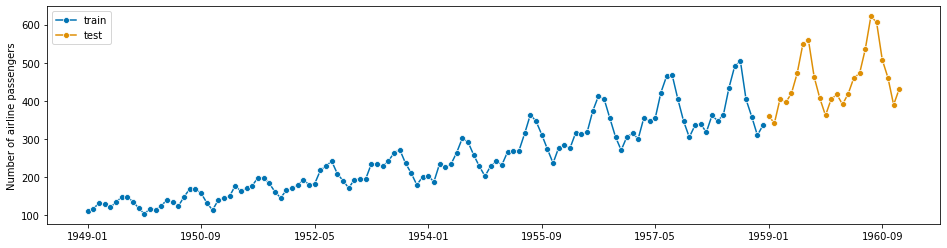

In [7]:
y_train, y_test = y[:-24], y[-24:]
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

### 2.1 Deseasonalization

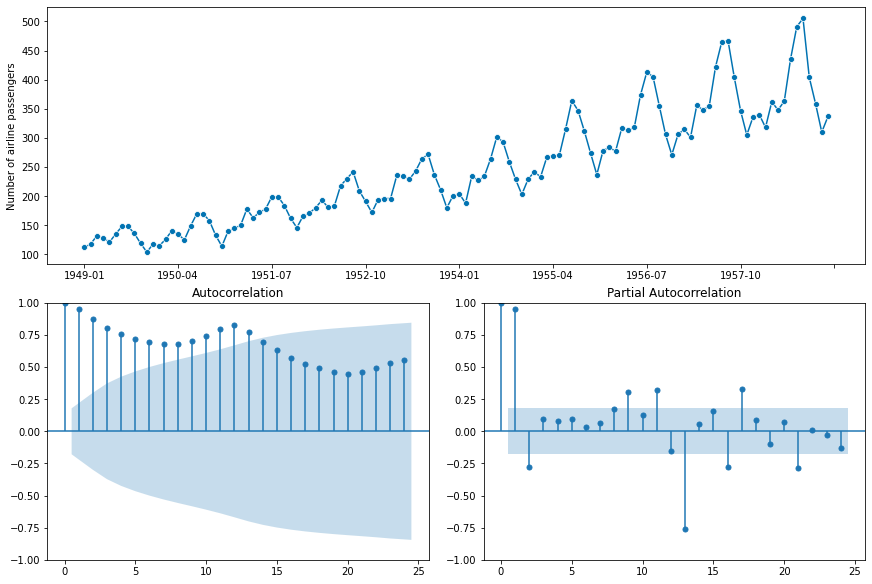

In [8]:
fig, ax = plot_correlations(y_train)

From the ACF plot we see that there is a seasonal pattern, and that there is a maximum at lag 12 indicating yearly seasonality. Let's remove it.

In [9]:
decompose_result = seasonal_decompose(y_train.values, period = 12, model="multiplicative")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

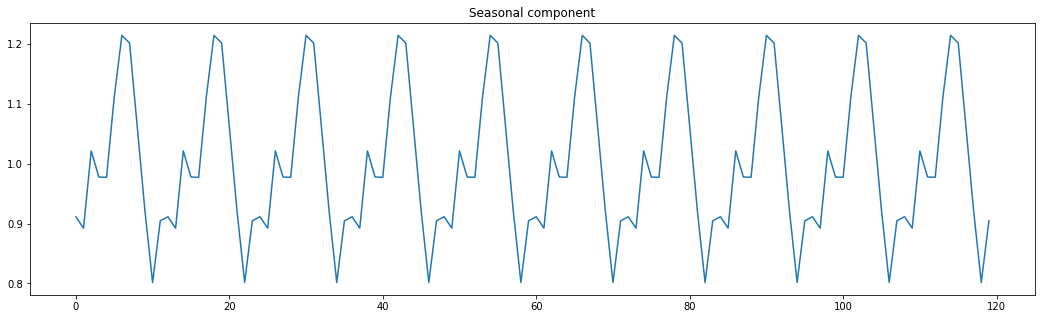

In [10]:
plt.figure(figsize=(18,5))
plt.title("Seasonal component")
plt.plot(seasonal)
plt.show()

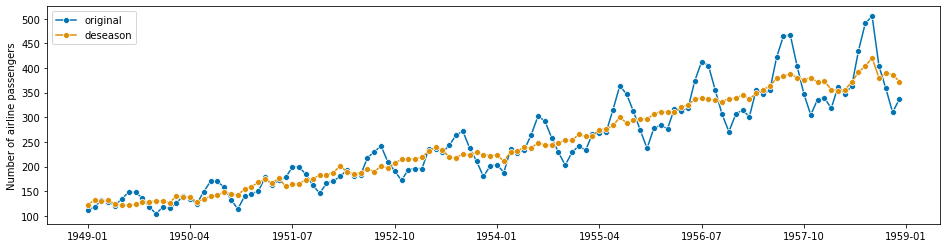

In [11]:
y_deseason = y_train/seasonal
fig, ax = plot_series(y_train, pd.Series(y_deseason, index=y.index), labels=["original", "deseason"])

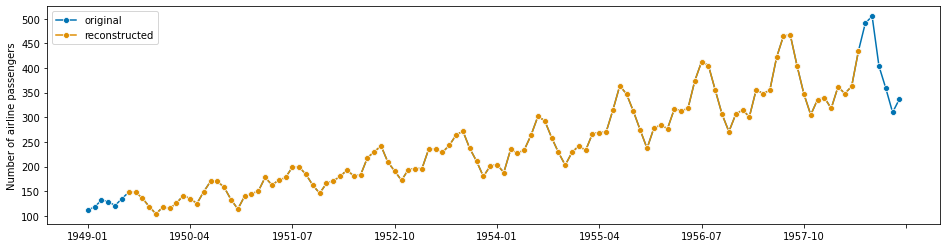

In [12]:
y_reconstructed = trend*seasonal*residual
fig, ax = plot_series(y_train,pd.Series(y_reconstructed, index=y_train.index), labels=["original", "reconstructed"])

### 2.2 Decomposition

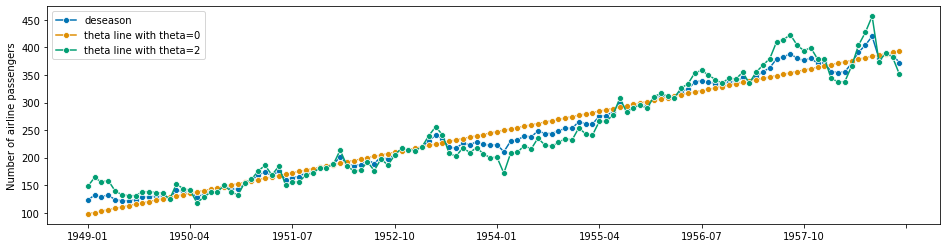

In [13]:
thetaline1 = get_theta_line(y_deseason, 0)
thetaline2 = get_theta_line(y_deseason, 2)
fig, ax = plot_series(pd.Series(y_deseason, index=y_train.index), thetaline1, thetaline2, labels=["deseason", "theta line with theta=0", "theta line with theta=2"])

### 2.3. Extrapolation

In [14]:
window = 24
fh_date = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1959-01", periods=window, freq="M")), is_relative=False
)
fh_date

ForecastingHorizon(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

In [15]:
fh_num = np.arange(len(y_train), len(y_train)+window, 1)
fh_num

array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143])

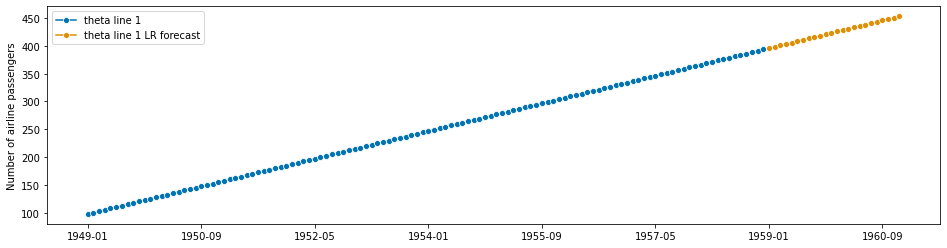

In [16]:
model = LinearRegression()
model = model.fit(np.arange(0, len(y_train), 1).reshape(-1, 1), thetaline1.values)
thetaline1_forecast = pd.Series(model.predict(fh_num.reshape(-1,1)), index = fh_date)
fig, ax = plot_series(thetaline1, thetaline1_forecast, labels=["theta line 1", "theta line 1 LR forecast"])

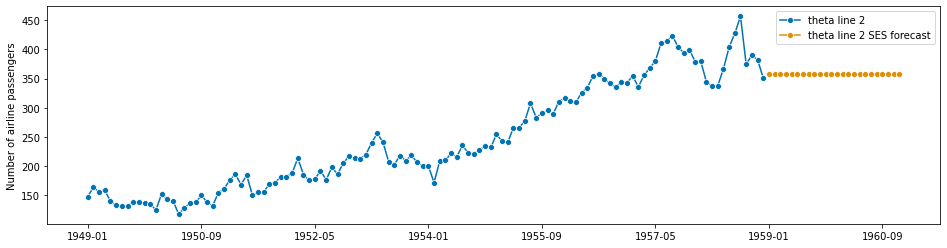

In [17]:
model = SimpleExpSmoothing(thetaline2)
alpha = 0.8
model = model.fit(smoothing_level=alpha)
thetaline2_forecast = model.forecast(window)
fig, ax = plot_series(thetaline2, thetaline2_forecast, labels=["theta line 2", "theta line 2 SES forecast"])

### 2.4. Combination

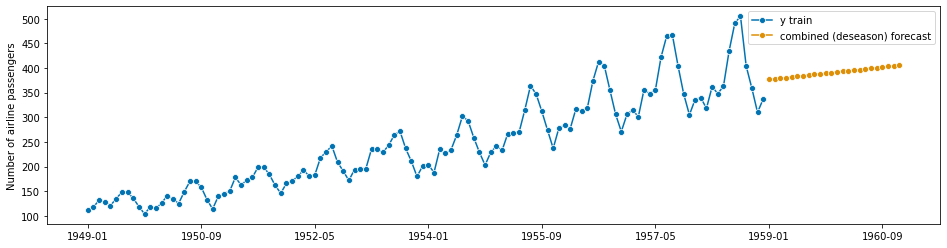

In [18]:
forecast_combined = 0.5*(thetaline1_forecast + thetaline2_forecast)
fig, ax = plot_series(y_train, forecast_combined, labels=["y train", "combined (deseason) forecast"])

### 2.5. Reseasonalization

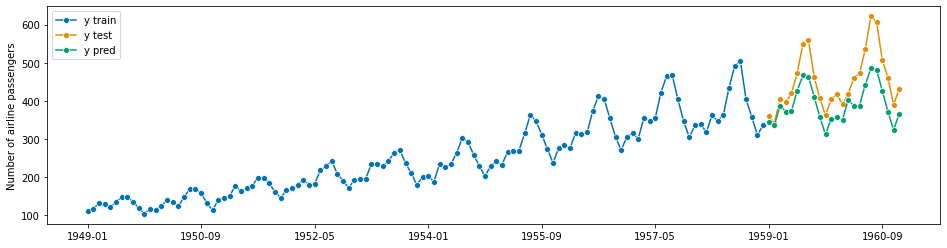

In [19]:
season = seasonal[-window:]
forecast_1 = forecast_combined*season
fig, ax = plot_series(y_train, y_test, forecast_1, labels=["y train", "y test", "y pred"])

### 2.6 BONUS: Improving extrapolation for theta line 2

/home/claudia/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/claudia/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/claudia/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


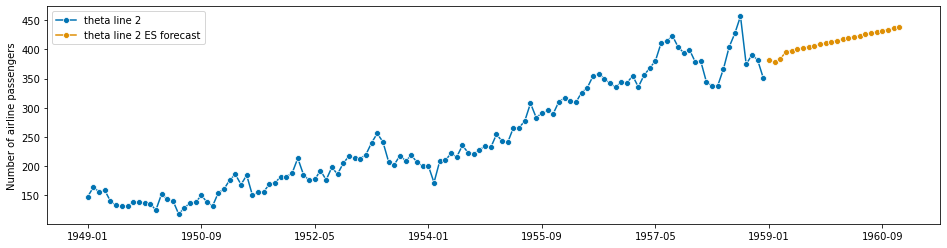

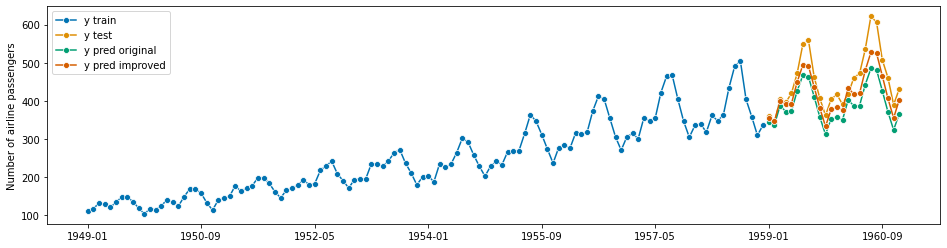

In [20]:
model = AutoARIMA(seasonal=False)
model = model.fit(thetaline2)
thetaline2_forecast = model.predict(fh_date)
fig, ax = plot_series(thetaline2, thetaline2_forecast, labels=["theta line 2", "theta line 2 ES forecast"])

forecast_deseason = 0.5*(thetaline1_forecast + thetaline2_forecast)

season = seasonal[-window:]
forecast_2 = forecast_deseason*season
fig, ax = plot_series(y_train, y_test, forecast_1, forecast_2, labels=["y train", "y test", "y pred original","y pred improved"])

In [21]:
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Improved Claudia model: {}".format(mae(y_test, forecast_2)))

MAE Original Claudia model: 61.00913096526104
MAE Improved Claudia model: 35.32712886410643


## 3. Comparison to library implementations

MAE Original Claudia model: 61.00913096526104
MAE Statsmodels model: 63.221630822604986


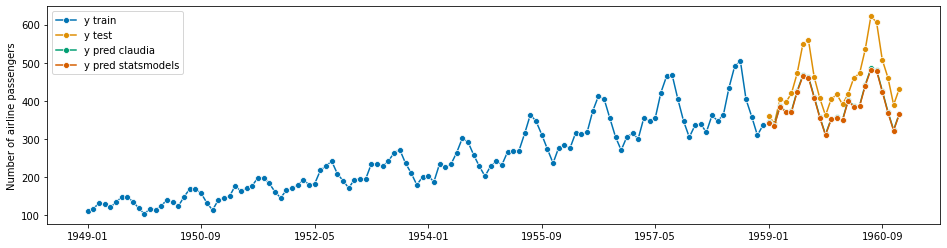

In [22]:
model = ThetaModel(y_train, period = 12)
model = model.fit()
forecast_3 = model.forecast(window)
fig, ax = plot_series(y_train, y_test, forecast_1, forecast_3, labels=["y train", "y test", "y pred claudia", "y pred statsmodels"])
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Statsmodels model: {}".format(mae(y_test, forecast_3)))

MAE Original Claudia model: 61.00913096526104
MAE Sktime model: 61.97150577043681


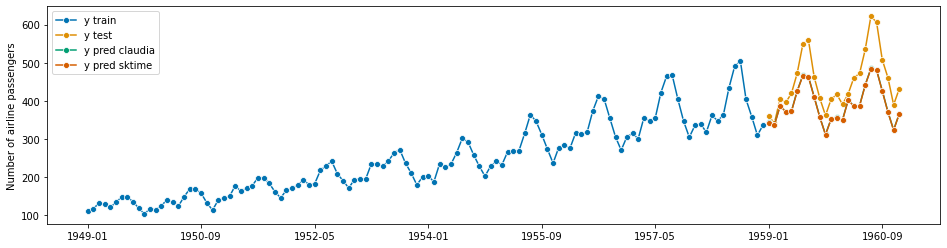

In [23]:
model = ThetaForecaster(sp=12)
model = model.fit(y_train)
forecast_4 = model.predict(fh_date)
fig, ax = plot_series(y_train, y_test, forecast_1, forecast_4, labels=["y train", "y test", "y pred claudia", "y pred sktime"])
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Sktime model: {}".format(mae(y_test, forecast_4)))

### 4. Critisizim: Unmasking the theta model

In [24]:
def theta_unmasked(x, alpha, h):
    n = len(x)
    b_hat_0 = (6/(n*n -1))*((2/n)*np.dot(x, np.arange(1, len(x)+1)) 
                     - ((1+n)/n)*np.sum(x))
    model = SimpleExpSmoothing(x)
    model = model.fit(alpha)
    x_forecast_ses = model.forecast(h)
    return x_forecast_ses + 0.5*b_hat_0*(np.arange(1,h+1)-1+1/alpha)

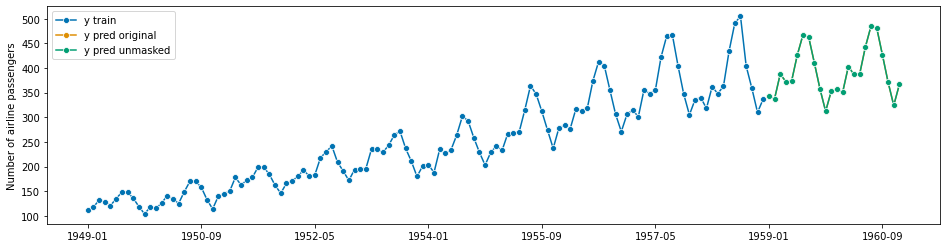

In [25]:
forecast_unmasked = theta_unmasked(y_deseason, alpha, window)
forecast_5 = forecast_unmasked*season
fig, ax = plot_series(y_train, forecast_1, forecast_5, labels=["y train", "y pred original", "y pred unmasked"])


In [26]:
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Unmasked Claudia model: {}".format(mae(y_test, forecast_5)))
print("The MAE between the original and the unmasked implementation is {:.2f}".format(mae(forecast_1, forecast_5)))

MAE Original Claudia model: 61.00913096526104
MAE Unmasked Claudia model: 61.00913096526103
The MAE between the original and the unmasked implementation is 0.00


https://github.com/Mcompetitions/M4-methods/blob/master/Benchmarks%20and%20Evaluation.R